In [3]:
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd, numpy as np, math
import matplotlib.pyplot as plt
import matplotlib.ticker, sklearn
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate


In [4]:
scopes = ['https://www.googleapis.com/auth/spreadsheets.readonly']

spreadsheet_id = '1Bex8dhklHWEC7SrlxrchqpJ7yU43XkbEvCYoxuVV6n8'
worksheet_name = 'da_assignment!A1:Z'

creds = None

if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
        
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('/home/trang/Downloads/credentials.json', scopes)
        creds = flow.run_local_server(port=0)

    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = build('sheets','v4', credentials = creds)

request_data = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=worksheet_name)
data = request_data.execute()

In [16]:
publications = pd.DataFrame(data['values'][1:], columns=data['values'][0])

In [383]:
## Clean data
## Remove NA values
publications['is_na'] = publications.isna().apply(sum,1)
sum(publications['is_na'] > 0)

0

In [18]:
## Empty value
# publications['is_empty'] = publications.apply(lambda x:x == '', 1).apply(sum,1)
empty_detail = publications.apply(lambda x:x == '', 0).apply(sum,0)
empty_detail

/home/trang/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


publication_time                     0
publication_id                       1
duplicate_id                         2
publication_channel                  0
publication_language                 0
predicted_relevance_probability      2
topic                               81
is_relevant                        335
verification_date                    0
is_na                                0
is_empty                             0
dtype: int64

In [153]:
## Clean empty value
publications['is_empty'] = ((publications['publication_id'] == '') | (publications['duplicate_id'] == '') | (publications['predicted_relevance_probability'] == ''))
publications_non_empty = publications[publications['is_empty'] == 0].copy()
publications_non_empty['predicted_relevance_probability']

0       0.8309
1       0.9015
2       0.8146
3       0.7276
4       0.8017
         ...  
1812    0.7717
1813    0.8147
1814     0.817
1815    0.6772
1816    0.7997
Name: predicted_relevance_probability, Length: 1813, dtype: object

In [201]:
## Remove duplicate duplicate_id values
publications_cleaned['predicted_relevance_probability'] = publications_cleaned['predicted_relevance_probability'].astype('float64')
publications_cleaned['publication_time'] = publications_cleaned['publication_time'].astype('datetime64[ns]')
publications_cleaned['verification_date'] = publications_cleaned['verification_date'].astype('datetime64[ns]')
publications_cleaned = publications_cleaned.mask(publications_cleaned == '', other='NA')
publications_cleaned = publications_cleaned.sort_values(['duplicate_id', 'verification_date', 'publication_time'], ascending = [True,False,True]).drop_duplicates(keep='first')


0

In [202]:
# Data aggregation
# aggregate by topic, return count of publication
agg_topic = publications_cleaned.groupby('topic').count()['publication_id'].sort_values()
agg_topic.shape

(26,)

In [203]:
# Aggregate by publication_language and publication_channel, return the count of publications
agg_language_channel = publications_cleaned.groupby(['publication_language','publication_channel']).count()['publication_id']

In [204]:
# Aggregate by publication_language and topic and is_relevant, return the count of publications
agg_language_topic_relevant = publications_cleaned.groupby(['publication_language','topic','is_relevant']).count()['publication_id']

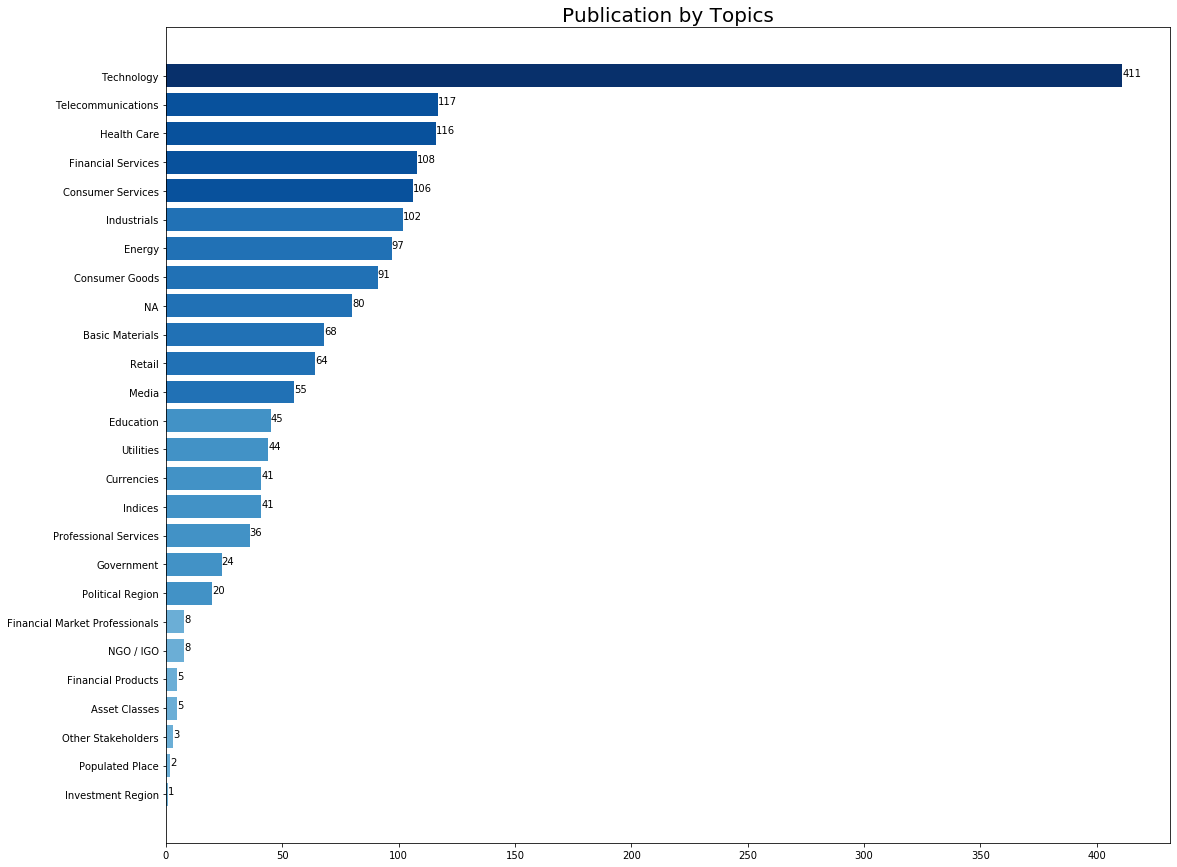

In [205]:
# Data Vizualization
all_topic_summary = agg_topic.values
all_topic_name = agg_topic.index
colors = ['#6baed6','#6baed6','#6baed6','#6baed6','#6baed6','#6baed6','#6baed6','#4292c6','#4292c6','#4292c6','#4292c6','#4292c6','#4292c6', '#4292c6',
          '#2171b5','#2171b5','#2171b5','#2171b5','#2171b5','#2171b5','#2171b5','#08519c', '#08519c', '#08519c', '#08519c', '#08306b']

fig = plt.figure(figsize = (18,15))
ax = fig.add_subplot(111)
    
plt.barh(y = all_topic_name, width = all_topic_summary, orientation = 'horizontal', color=colors)
plt.title('Publication by Topics', fontsize=20)

for index,val in enumerate(all_topic_summary):
    ax.text(val,index,str(val), fontsize=10)

Text(0.5, 1.0, 'Publication by Topics and Language')

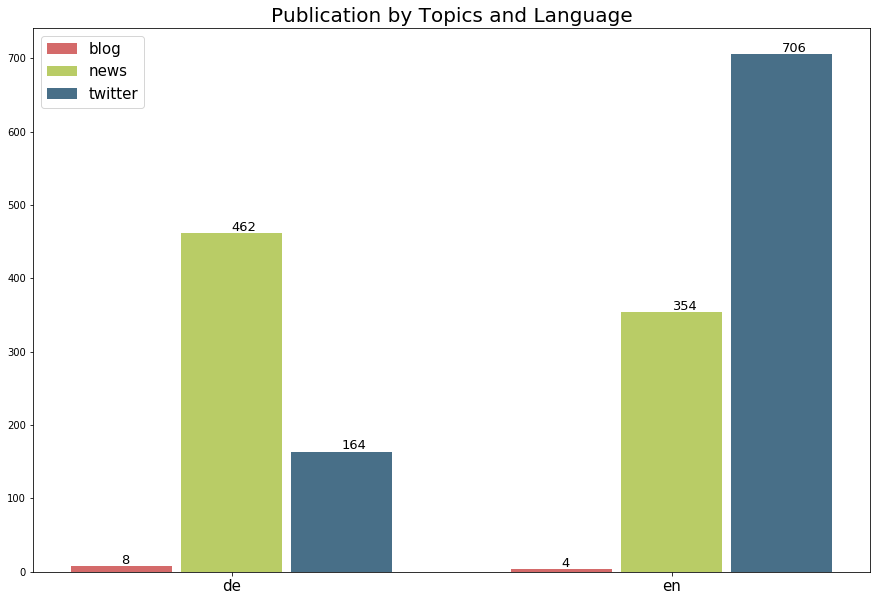

In [371]:
agg_language_channel
agg_language_channel_reset = agg_language_channel.reset_index()

width = 0.55

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)
languages = agg_language_channel_reset['publication_language'].drop_duplicates().values
channels = agg_language_channel_reset['publication_channel'].drop_duplicates().values
colors = ['#D46A6A', '#B9CC66', '#486F88']
xticks = []
xticklabels = []
        
## Create chart and legend
for channel_idx, channel in enumerate(channels):
    counts = []
    indexes = []
    lang_indexes = []
    for idx,language in enumerate(languages):
        is_valid_condition = ((agg_language_channel_reset['publication_language'] == language) & (agg_language_channel_reset['publication_channel'] == channel))
        counts.append(int(agg_language_channel_reset[is_valid_condition]['publication_id']))
        indexes.append(agg_language_channel_reset[is_valid_condition].index[0])
        lang_indexes.append(idx)
    
    x_chart = (np.array(indexes) + np.array(lang_indexes))*0.6
    plt.bar(x_chart, counts, width=width, color=colors[channel_idx], label=channel)

    for x,y, dis in zip(indexes, counts, lang_indexes):
        ax.text((x + dis) * 0.6, y+ 3, str(y), fontsize=13)

## Add groups name
for idx, language in enumerate(languages):
    is_valid_condition = ((agg_language_channel_reset['publication_language'] == language))
    indexes = agg_language_channel_reset[is_valid_condition].index
    mid = math.floor(len(indexes) / 2)
    xticks.append((indexes[mid] + idx ) * 0.6)
    xticklabels.append(language)     
    
ax.legend(fontsize=15)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=15)
plt.title('Publication by Topics and Language', fontsize=20)

In [1]:

plt.figure(figsize=(15,10))

predicted_relevance_probability = np.round(np.array(publications_cleaned['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)
plt.show()

NameError: name 'plt' is not defined

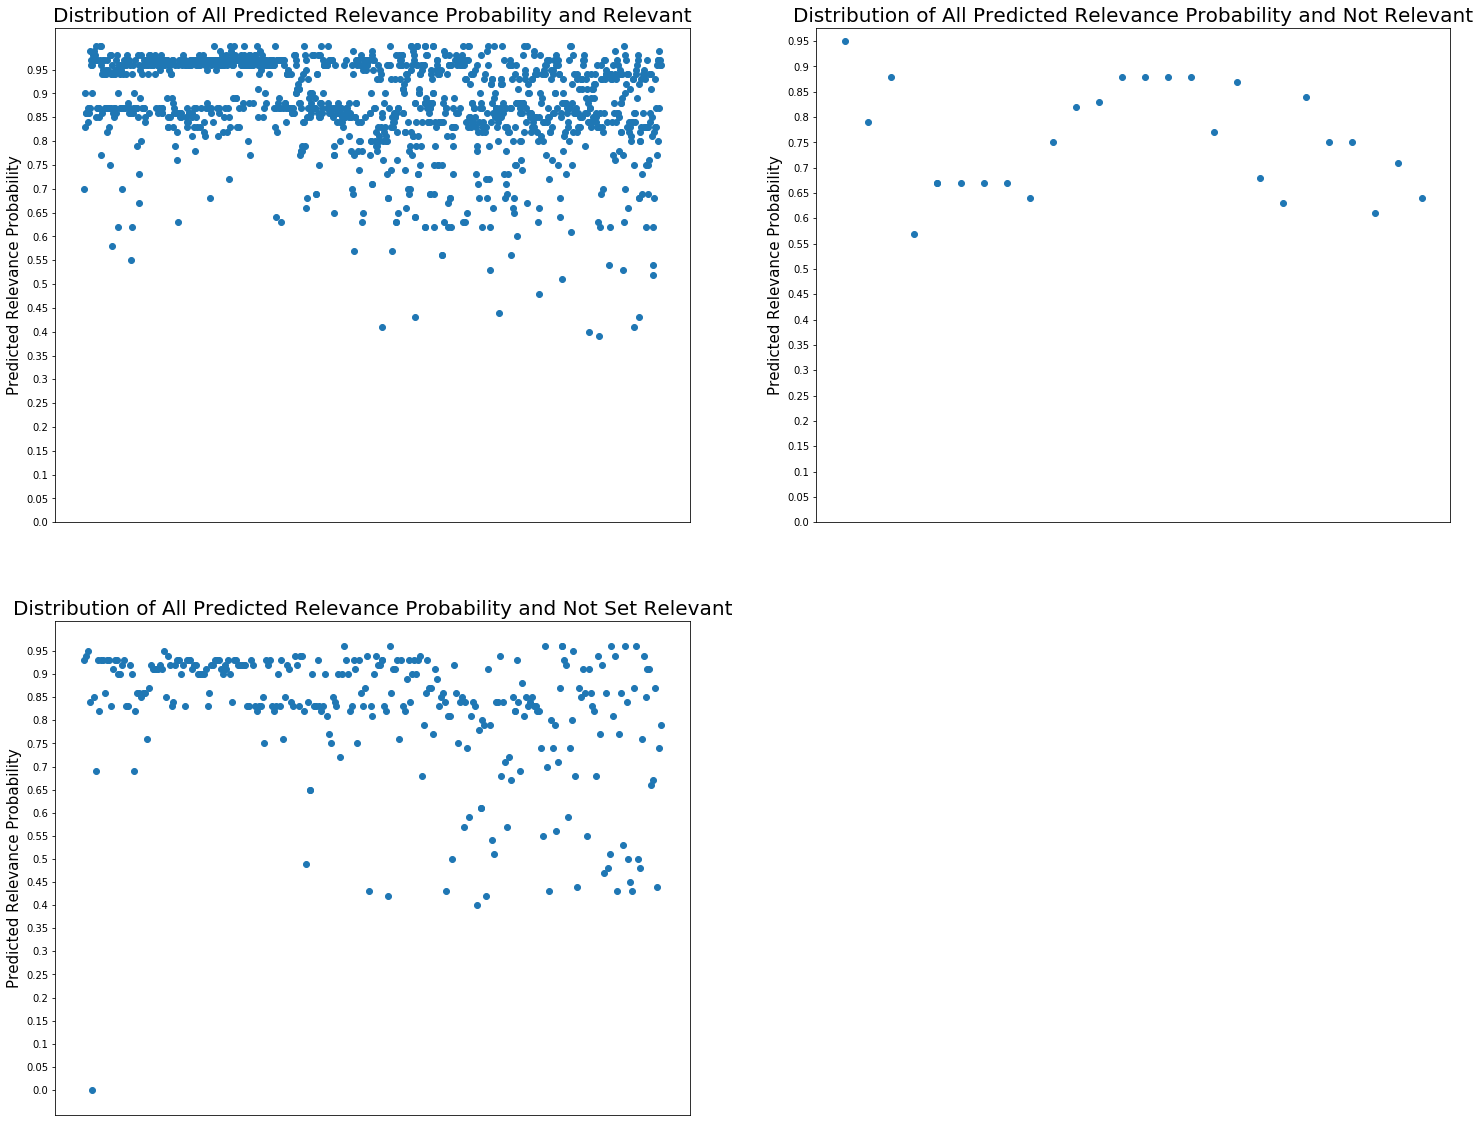

In [212]:
fig = plt.figure(figsize=(25,20))

plt.subplot(221)
is_relevant = publications_cleaned['is_relevant'] == 'TRUE'

predicted_relevance_probability = np.round(np.array(publications_cleaned[is_relevant]['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned[is_relevant]['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability and Relevant', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)

plt.subplot(222)
not_relevant = publications_cleaned['is_relevant'] == "FALSE"

predicted_relevance_probability = np.round(np.array(publications_cleaned[not_relevant]['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned[not_relevant]['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability and Not Relevant', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)

plt.subplot(223)
not_relevant = publications_cleaned['is_relevant'] == "NA"

predicted_relevance_probability = np.round(np.array(publications_cleaned[not_relevant]['predicted_relevance_probability'], dtype=float),2)

plt.scatter(x = publications_cleaned[not_relevant]['publication_id'], y = predicted_relevance_probability)
plt.yticks(np.arange(0, 1, step=0.05),np.round(np.arange(0, 1, step=0.05),2))
plt.xticks([],[])
plt.title('Distribution of All Predicted Relevance Probability and Not Set Relevant', fontsize=20)
plt.ylabel('Predicted Relevance Probability', fontsize=15)

plt.show()

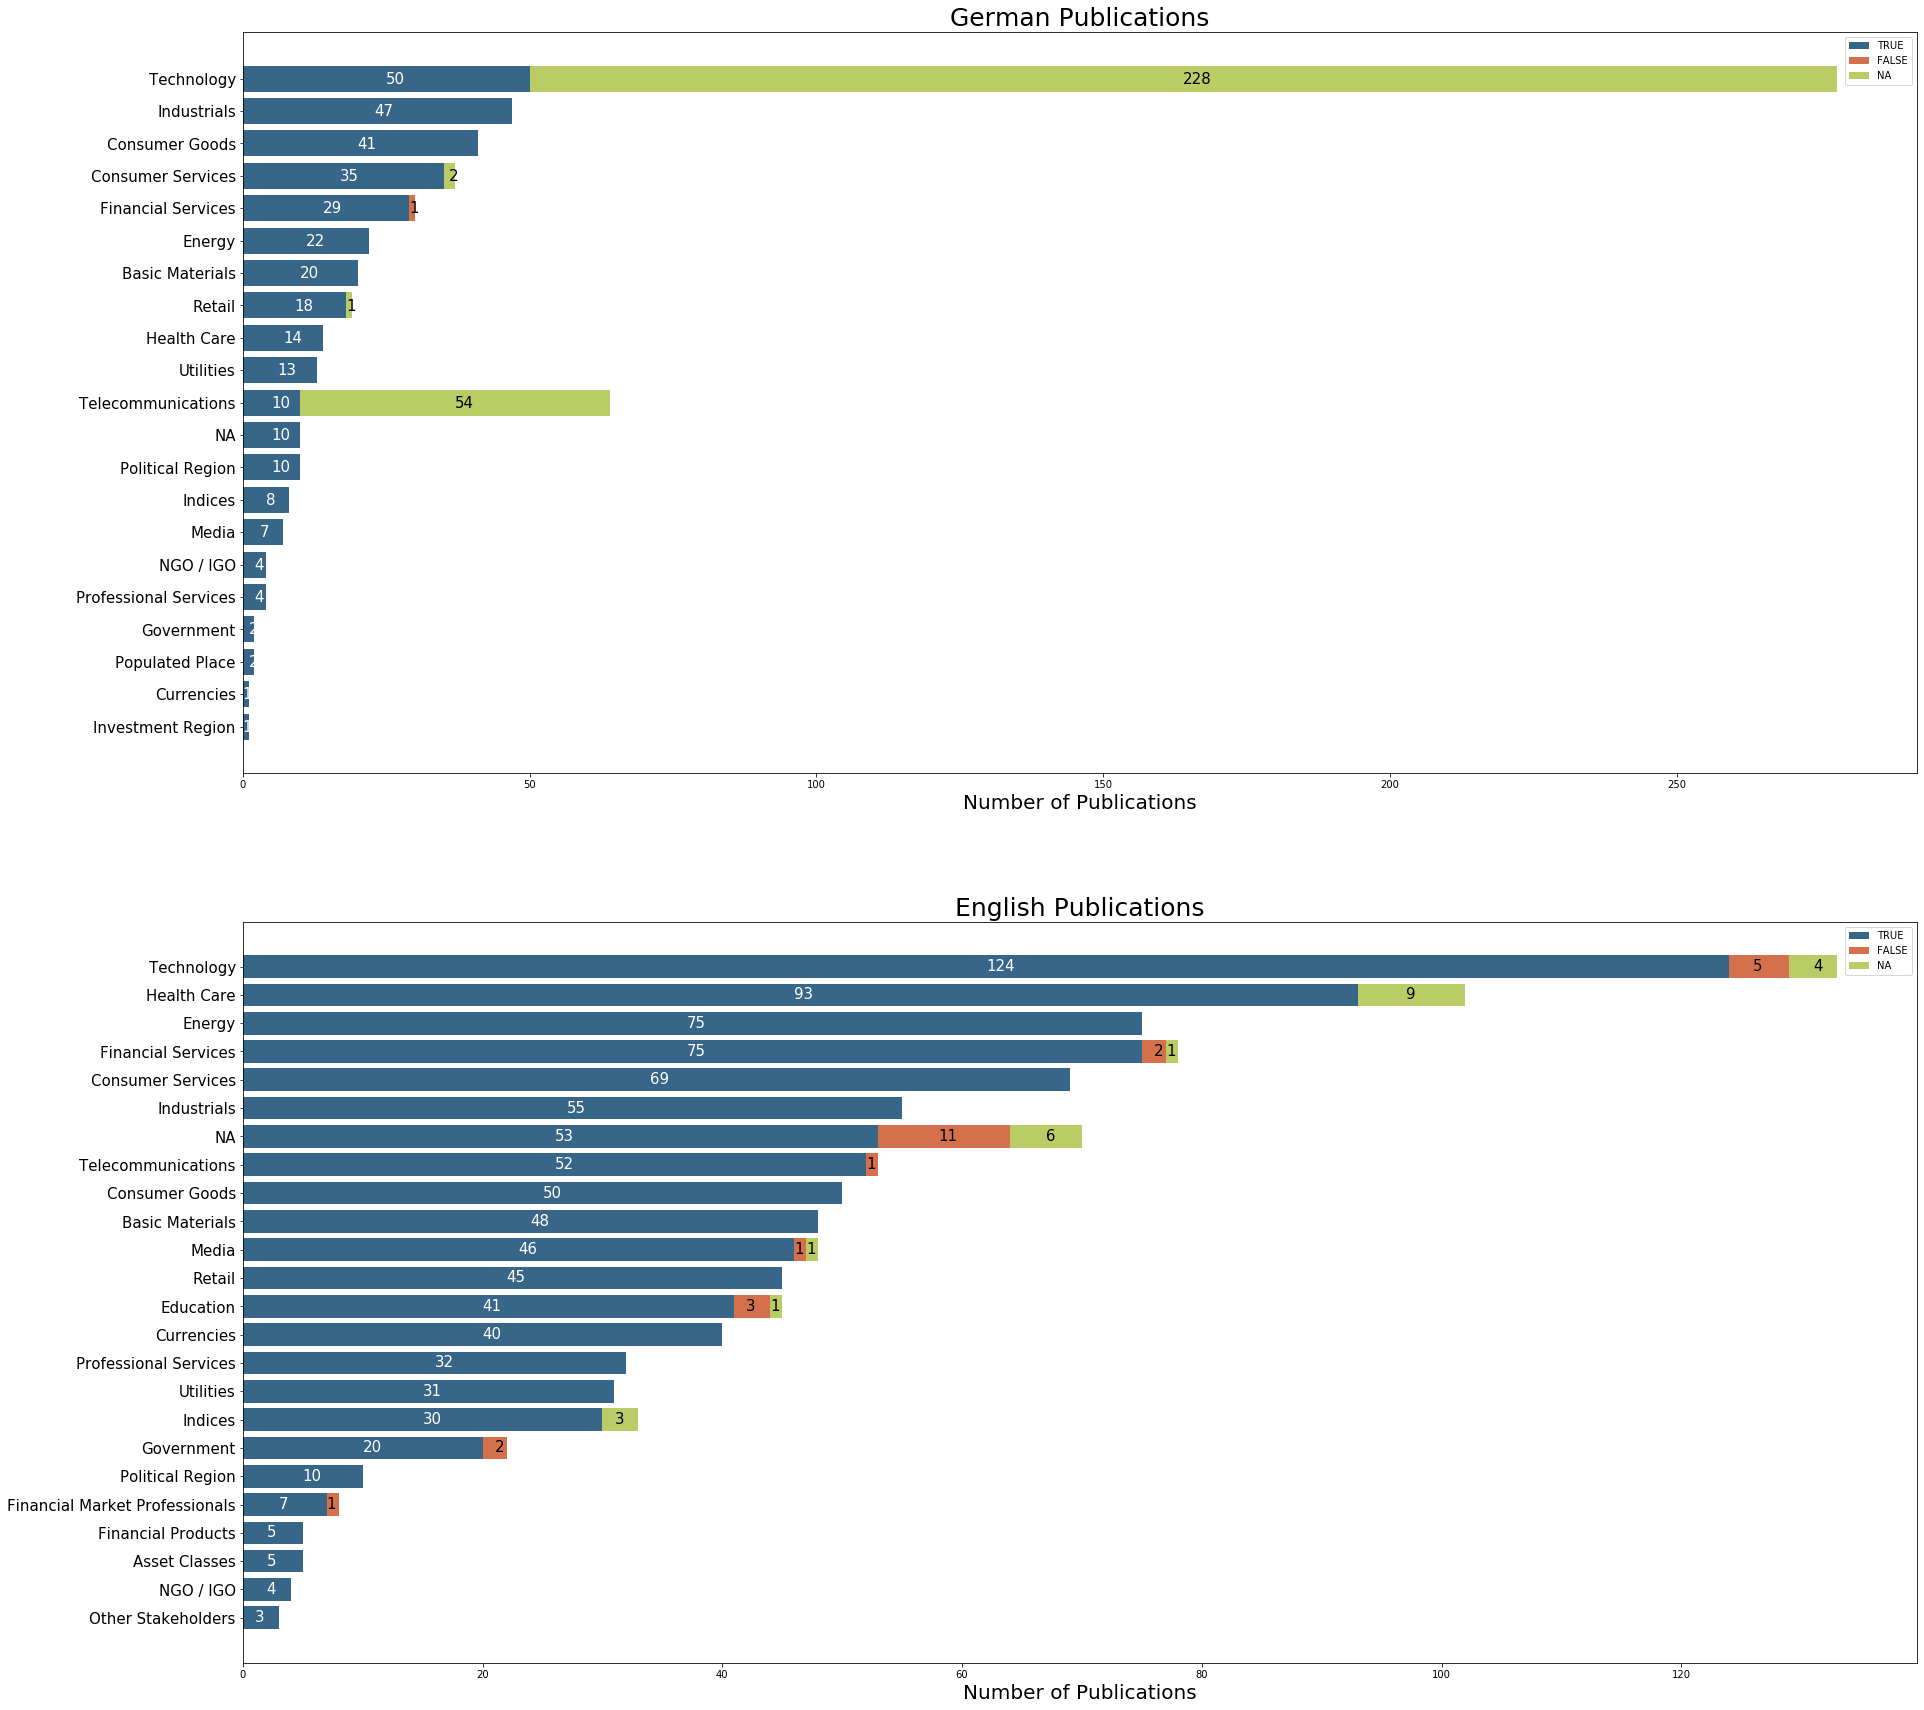

In [245]:
language_dict = {'en':'English', 'de':'German'}
agg_language_topic_relevant_reset = agg_language_topic_relevant.reset_index()
agg_language_topic_relevant_reset = agg_language_topic_relevant_reset.rename(columns={'publication_id':'counts'})
agg_language_topic_relevant_reset

all_languages = agg_language_topic_relevant_reset['publication_language'].drop_duplicates().values

ncols_subplots = 1
nrows_subplots = math.floor(len(all_languages) / ncols_subplots)

fig = plt.figure(figsize=(30,30))

for idx_lan, language in enumerate(all_languages):    
    ax = plt.subplot(nrows_subplots, ncols_subplots, idx_lan+1)
    data_by_language = agg_language_topic_relevant_reset[agg_language_topic_relevant_reset['publication_language'] == language].sort_values(by='counts')
    data_by_language = data_by_language.reset_index(drop=True)   
    
    ## relevant values
    data_relevant = data_by_language[data_by_language['is_relevant'] == 'TRUE'].reset_index(drop=True)
    topics = data_relevant['topic']
    counts = data_relevant['counts']
    plt.barh(topics,counts, label='TRUE', color='#386689')
    
    for idx, number in enumerate(counts):
        x_loc = math.floor(number / 2)
        ax.text(x_loc, idx - 0.15, str(number), fontsize=15, color='white')
    
    ## not relevant values
    data_not_relevant = data_by_language[data_by_language['is_relevant'] == 'FALSE']
    data_merge = pd.merge(data_not_relevant, data_relevant, how='inner', on='topic', suffixes=['_not_relevant', '_relevant']).copy()
    n_topics = data_merge['topic']
    n_counts = data_merge['counts_not_relevant']
    n_left = data_merge['counts_relevant']
    n_bottom_indexes = topics[topics.isin(n_topics)].index
    plt.barh(n_topics, n_counts, label='FALSE', left=n_left, color='#D5704D')  

    for idx, (number, bottom, topic) in enumerate(zip(n_counts, n_left, n_topics)):
        x_loc = math.floor(number / 2) + bottom
        y_loc = (topics[topics.isin([topic])].index.values)[0]
        ax.text(x_loc, y_loc - 0.15, str(number), fontsize=15)
        
     ## empty relevant values
    data_empty_relevant = data_by_language[data_by_language['is_relevant'] == 'NA']
    data_empty_merge = pd.merge(data_empty_relevant, data_relevant, how='inner', on='topic', suffixes = ['_empty_relevant', '_relevant'])
    data_empty_merge = pd.merge(data_empty_merge, data_not_relevant, how='left', on='topic', suffixes = ['', '_not_relevant'])
    data_empty_merge['counts'] = data_empty_merge['counts'].fillna(0)
    
    empty_topics = data_empty_merge['topic']
    empty_counts = data_empty_merge['counts_empty_relevant']
    empty_left = data_empty_merge['counts_relevant'] + data_empty_merge['counts']
    
    empty_bottom_indexes = topics[topics.isin(n_topics)].index
    plt.barh(empty_topics, empty_counts, label='NA', left=empty_left, color='#B9CC66')  

    for idx, (number, bottom, topic) in enumerate(zip(empty_counts, empty_left, empty_topics)):
        x_loc = math.floor(number / 2) + bottom
        y_loc = (topics[topics.isin([topic])].index.values)[0]
        ax.text(x_loc, y_loc - 0.15, str(number), fontsize=15)
        
    plt.legend()
    plt.xlabel('Number of Publications', fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(language_dict[language] + ' Publications', fontsize=25)
    
plt.show()

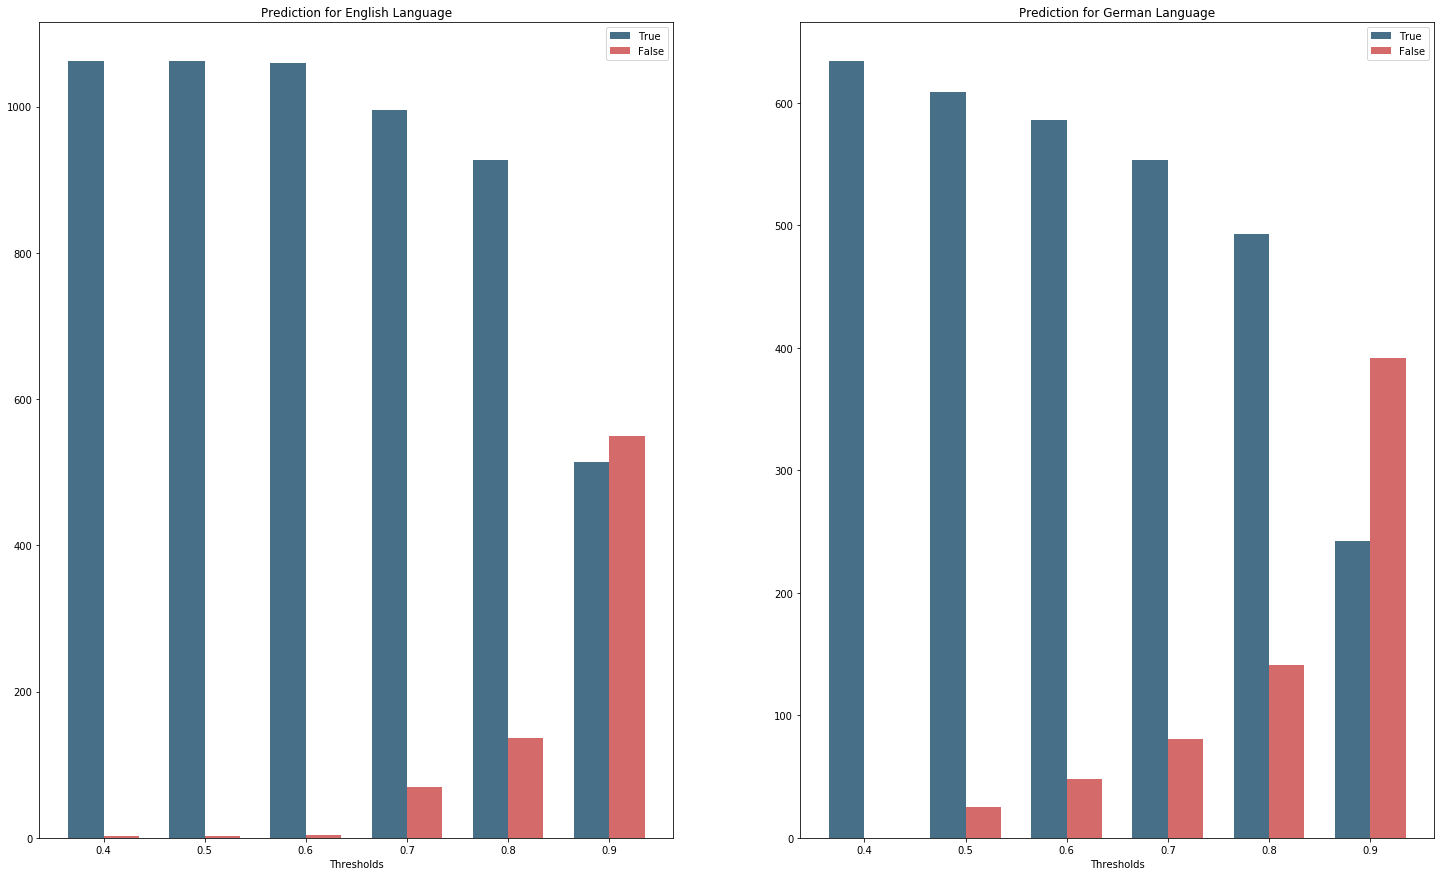

In [380]:
classification_dataset = publications_cleaned.copy()
all_thresholds = [0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
all_languages = classification_dataset['publication_language'].drop_duplicates()
language_dict = {'en': 'English', 'de': 'German'}

fig = plt.figure(figsize=(25,15))

for idx, language in enumerate(all_languages):
    ax = plt.subplot(1, 2, idx+1)
    classification_dataset_language = classification_dataset[classification_dataset['publication_language'] == language].copy()
    true_values = {}
    false_values = {}
    
    for threshold in all_thresholds:
        classification_dataset_language['prediction'] = classification_dataset_language['predicted_relevance_probability'] >= threshold
        summary = classification_dataset_language.groupby('prediction').count()['publication_time']
        summary = summary.reset_index()
        summary = summary.rename({'publication_time':'counts'}, axis=1)
        true_values[threshold] = 0 if len(summary[summary['prediction']]['counts'].values) == 0 else summary[summary['prediction']]['counts'].values[0]
        false_values[threshold] = 0 if len(summary[~ summary['prediction']]['counts'].values) == 0 else summary[~ summary['prediction']]['counts'].values[0]
    
    x_loc_true = np.arange(len(true_values))
    width = 0.35
    plt.bar(x_loc_true - width/2,list(true_values.values()), width=width, label='True', color = '#486F88')
    plt.bar(x_loc_true + width/2, list(false_values.values()), width=width, label='False', color = '#D46A6A')
    plt.legend()
    ax.set_xticks(x_loc_true)
    ax.set_xticklabels(all_thresholds)
    plt.xlabel('Thresholds')
    plt.title('Prediction for ' + language_dict[language] + ' Language')



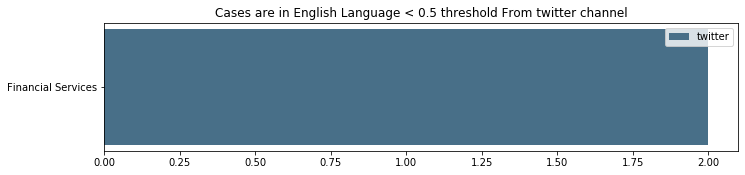

In [377]:
classification_dataset = publications_cleaned.copy()
all_thresholds = [0.5]
all_languages = classification_dataset['publication_language'].drop_duplicates()

fig = plt.figure(figsize=(25,8))
start = 1
colors = ['#486F88', '#D46A6A', '#B9CC66']
for idx, language in enumerate(all_languages):
    if language == 'en':
        classification_dataset_language = classification_dataset[classification_dataset['publication_language'] == language].copy()   
        for threshold in all_thresholds:
            ax = plt.subplot(3, 1, start)
            start += 1
            classification_dataset_language['prediction'] = classification_dataset_language['predicted_relevance_probability'] >= threshold
            false_dataset = classification_dataset_language[~classification_dataset_language['prediction']]
            summary = false_dataset.groupby(['topic', 'publication_channel']).count()['publication_time'].sort_values()
            summary = summary.reset_index()
            summary = summary.rename({'publication_time':'counts'}, axis=1)
            all_channels = summary['publication_channel'].drop_duplicates()
            for idx, channel in enumerate(all_channels):
                ax = plt.subplot(3, 2, start)
                start += 1
                summary_channel = summary[summary['publication_channel'] == channel]
                plt.barh(summary_channel['topic'], summary_channel['counts'], label=channel, height = 0.8, color = colors[idx])
                plt.legend()
                plt.title('Cases are in English Language < ' + str(threshold) + ' threshold From ' + channel + ' channel')
        
  

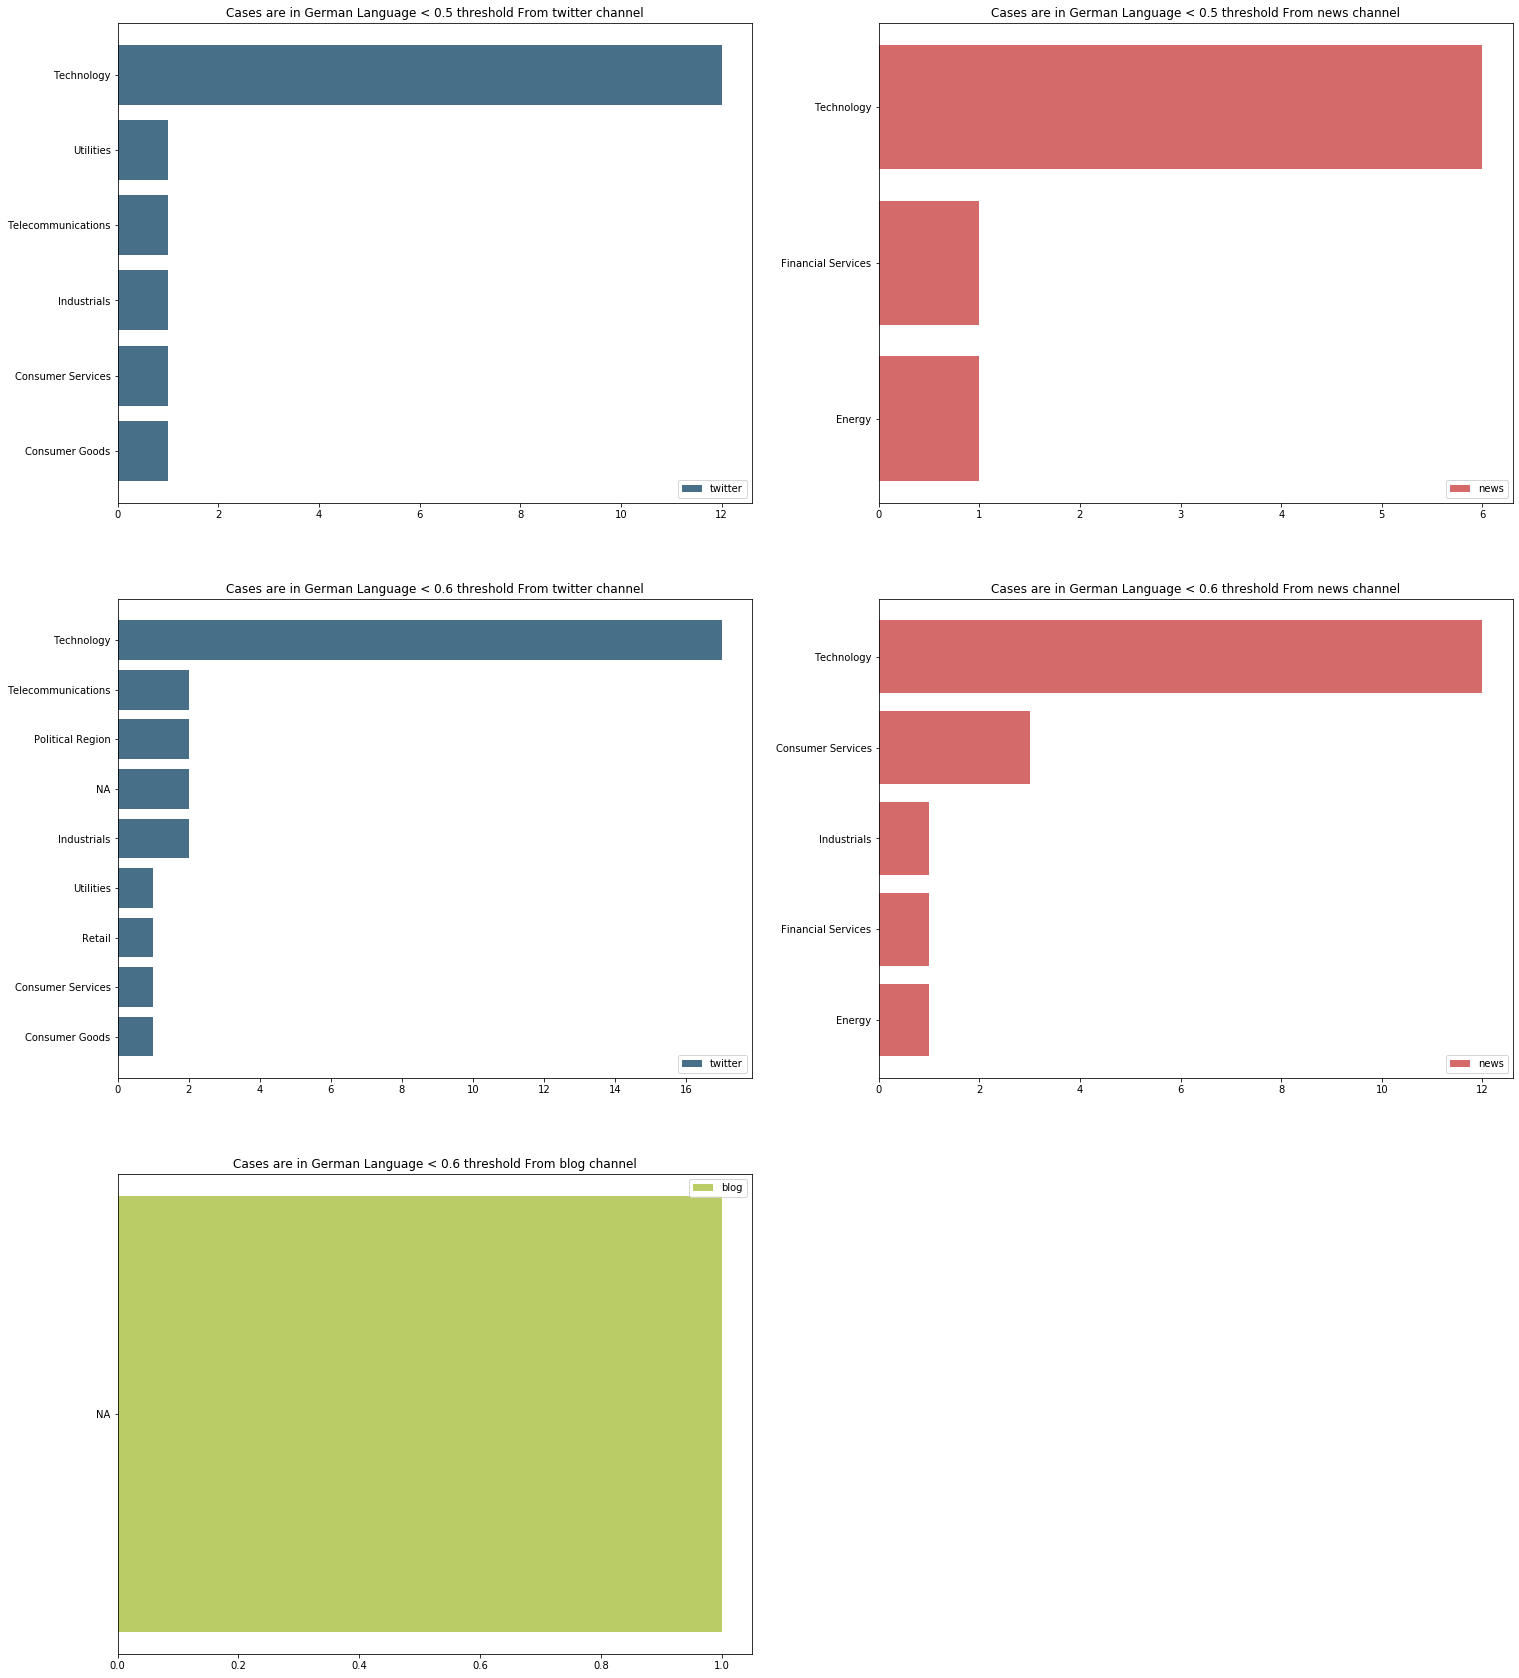

In [372]:
classification_dataset = publications_cleaned.copy()
all_thresholds = [0.5, 0.6]
all_languages = classification_dataset['publication_language'].drop_duplicates()

fig = plt.figure(figsize=(25,30))
start = 1
colors = ['#486F88', '#D46A6A', '#B9CC66']
for idx, language in enumerate(all_languages):
    if language == 'de':
        classification_dataset_language = classification_dataset[classification_dataset['publication_language'] == language].copy()   
        for threshold in all_thresholds:
            classification_dataset_language['prediction'] = classification_dataset_language['predicted_relevance_probability'] >= threshold
            false_dataset = classification_dataset_language[~classification_dataset_language['prediction']]
            summary = false_dataset.groupby(['topic', 'publication_channel']).count()['publication_time'].sort_values()
            summary = summary.reset_index()
            summary = summary.rename({'publication_time':'counts'}, axis=1)
            all_channels = summary['publication_channel'].drop_duplicates()
            for idx, channel in enumerate(all_channels):
                ax = plt.subplot(3, 2, start)
                start += 1
                summary_channel = summary[summary['publication_channel'] == channel]
                plt.barh(summary_channel['topic'], summary_channel['counts'], label=channel, height = 0.8, color = colors[idx])
                plt.legend()
                plt.title('Cases are in German Language < ' + str(threshold) + ' threshold From ' + channel + ' channel')
            
           

* As you can see for the new analysis:
    * Due to the is_relevant exposes some row with empty values and false with high predicted_relevance_probability (> 0.5)
    * I changed threshold from 0.4 to 0.9 and check values from 2 languages : English and German. English keeps 2 records false for 0.4, 0.5 and 0.6 thresholds. German has false values increasing for 0.5 and 0.6 thresholds.
    * Dig into topic and channel of German, data shown that most of false case come from technology topic and in twitter and news channels. 
    * We also have a little issue that 80 topics come with empty value. we should go through this.
* Inconclusion, we should consider publications those related to technology topic and some topics are from twitter and news channels: Financial Services, Customer Services, Energy, Telecommunications, Ultilities, Industrial, Retail and Consumer Goods.